# Distributions of Hurst exponent values in cryptocurrency trading close price time series samples
## Question
What is the smallest time series window size that consistently exhibits long-term positive autocorrelation (i.e. most sampled chart data windows contain enough information so that it is possible to discern some trend)? More formally, we are looking for window size ***W***, such that [Hurst exponent](http://www.bearcave.com/misl/misl_tech/wavelets/hurst/) value ***H > 0.5 + ε*** for ***n*** time series of length ***W*** in a sample of size ***N*** such that ***n/N > ω***, where ***ε*** and ***ω*** are some threshold values and ***n < N***.
## Motivation
This information may be useful in determining the optimal time series window size that can be used for sampling larger time series data; this sampled data can be used as an input to a fixed-input size machine learning model. Making sure that most time series inputs to the ML model exhibit long-term positive autocorrelation ensures that learning useful features from the data from similar distributions and making accurate predictions is manageable. In my opinion, trying to assign some labels to time series that follow geometric random walk mode and feeding it to a machine learning model is counterproductive.

In [1]:
import os
import concurrent.futures
import nolds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from random import randint
%matplotlib inline
import seaborn as sns
sns.set()
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,15)

In [2]:
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', 'data')) # path to the directory with chart data CSVs

## Market data preprocessing and distribution calculations
Here, several functions for streamlining data samlpling and and calculation of Hurst exponents are defined. 

`sample_time_windows()` is used to return all possible unique overlapping time windows of size `window_size` timesteps. 

Example: 

`list(df_ohlc['close']) = [0, 1, 2, 3, 4]`, `window_size = 3`. 

Then, `sample_time_windows(df_ohlc, window_size)` returns matrix `[[0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 5]]`.

In [3]:
def sample_time_windows(df_ohlc, window_size):
    """Returns sample of all possible unique overlapping time windows of size `window_size` timesteps."""
    n_tsteps = df_ohlc.shape[0] # number of timesteps in data
    assert n_tsteps >= window_size
    df_chart_data = df_ohlc['close']
    n_windows = n_tsteps - window_size + 1 # max number of unique overlapping samples
    windows = np.empty((n_windows, window_size), dtype=np.float32)
    for i in range(n_windows):
        window = df_chart_data.iloc[i:i + window_size].as_matrix()
        windows[i,:] = window
    return windows # returns matrix with shape (n_windows, window_size)

`sample_time_windows()` returns vector of Hurst exponents for every window returned by `sample_time_windows()`.

`calc_windows_hurst_exp_wrapper()` is needed since it is not possible to pass more than one argument to a function inside ProcessPoolExecutor's map method.

In [4]:
def calc_windows_hurst_exp(df_ohlc, window_size):
    """Returns vector of Hurst exponents for all possible unique overlapping time windows of size `window_size` timesteps."""
    windows = sample_time_windows(df_ohlc=df_ohlc, window_size=window_size)
    n_windows = windows.shape[0]
    windows_hurst_exps = np.empty((n_windows), dtype=np.float32)
    for i in range(n_windows):
        windows_hurst_exps[i] = nolds.hurst_rs(windows[i,:], fit="poly", corrected=True, unbiased=True)
    return windows_hurst_exps # vector with shape (n_windows,)

def calc_windows_hurst_exp_wrapper(df_ohlc_and_window_size):
    return calc_windows_hurst_exp(*df_ohlc_and_window_size)

`calc_samples_hurst_exp()` creates processes that asynchronously calculate Hurst exponents for every unique overlapping window in `df_ohlc` using windows of different sizes.

In [5]:
def calc_samples_hurst_exp(df_ohlc, window_sizes):
    """Returns list of vectors, each with Hurst exponents for all possible unique overlapping time windows"""
    df_ohlc_and_window_size = list(zip([df_ohlc] * len(window_sizes), window_sizes))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")   # suppress "Polyfit may be poorly conditioned"
        samples_hurst_exps = []
        # may take quite some time...
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for windows_hurst_exps in executor.map(calc_windows_hurst_exp_wrapper, df_ohlc_and_window_size):
                samples_hurst_exps.append(windows_hurst_exps)
        return samples_hurst_exps

Try 6 window sizes from 64 to 2048 in powers of 2. Hurst exponents of smaller time series lead to high variance of the R/S estimates [\[1\]](https://www.sciencedirect.com/science/article/pii/S0378437102009615?via%3Dihub#aep-abstract-id11).

In [6]:
window_sizes = list(2**np.arange(6,12))

In [7]:
# first try XMR/LTC pair close prices with candlestick period of 900 seconds
poloniex_xmr_ltc_900_df = pd.read_csv(os.path.join(data_dir, 'poloniex_XMR_LTC_900.csv'), index_col=0)

In [8]:
poloniex_xmr_ltc_900_hurst_exps = calc_samples_hurst_exp(df_ohlc=poloniex_xmr_ltc_900_df, window_sizes=window_sizes)

The following step is needed to remove possible NaNs from each `sample_hurst_exps` vector in `samples_hurst_exps` list. Here is why NaNs may appear in some of the vectors in the first place:

Hurst exponent is undefined for time-series window where every value is the same. All R/S values are zero for such time series, making it impossible to use points ***(log(size_of_subseries), log(R/S))*** for fitting a linear regression line for Hurst exponent approximation. See more: https://github.com/CSchoel/nolds/blob/3ce2a9003a1bad5179b4ebdad4d2c4a3cd519522/nolds/measures.py#L1167

In [9]:
def remove_nans(samples_hurst_exps):
    valid_samples_hurst_exps = []
    for sample_hurst_exps in samples_hurst_exps:
        if np.any(np.isnan(sample_hurst_exps)):
            mask = np.isnan(sample_hurst_exps)
            valid_samples_hurst_exps.append(sample_hurst_exps[~mask])
        else:
            valid_samples_hurst_exps.append(sample_hurst_exps)
    return valid_samples_hurst_exps

The next step is needed to remove unusual Hurst exponent values. I define unusual Hurst exponent values as follows: ***H ≥ 1 or H ≤ 0***. Although nothing prevents the slope of the linear fit to points ***(log(size_of_subseries), log(R/S))*** during R/S estimation to be outside of the range ***(0,1)***, it rarely occurs. No literature on Hurst exponent that I have seen talks about the meaning of Hurst exponent outside of ***(0,1)***.

If values outside of ***(0,1)*** range occur, it is most likely due to extreme outliers; a linear fit with [RANSAC](https://en.wikipedia.org/wiki/Random_sample_consensus) is more robust to outliers, but takes a lot longer to compute compared to a polynomial fit used here. Since I needed to compute Hurst exponent for a considerably large number of time series, I used the less time consuming method and removed values that were affected by outliers (no more than 10% for any example in this code). 

*Note that removing NaNs and unusual values is only important for plotting nice-looking histograms. Complete sets of **H** values are used for time series visualisation part later.*

In [10]:
def remove_unusual(samples_hurst_exps):
    usual_samples_hurst_exps = []
    fracs_unusual = []
    for sample_hurst_exps in samples_hurst_exps:
        mask = np.logical_and(sample_hurst_exps<1, sample_hurst_exps>0)
        usual_samples_hurst_exps.append(sample_hurst_exps[mask])
        frac_unusual = (sample_hurst_exps.shape[0] - len(sample_hurst_exps[mask])) / sample_hurst_exps.shape[0]
        fracs_unusual.append(frac_unusual)
    return usual_samples_hurst_exps, fracs_unusual

In [12]:
poloniex_xmr_ltc_900_hurst_exps_clean, fracs_unusual = remove_unusual(remove_nans(poloniex_xmr_ltc_900_hurst_exps))

Plot distributions of Hurst exponent values for XMR/LTC trading pair's close prices with candlestick period of 900 seconds.

In [13]:
def plot_hurst_exp_distribution(hurst_exps, window_sizes, fracs_unusual, data_name):
    n_plots = len(hurst_exps)
    i = 0
    f, axarr = plt.subplots(int(np.ceil(n_plots / 2)), 2)
    for r in range(int(np.ceil(n_plots / 2))):
        for c in range(2):
            sns.kdeplot(hurst_exps[i], ax=axarr[r, c], shade=True)
            axarr[r, c].set_title('window size: {ws:0d}, mean: {mean:0.4f}, std: {std:0.4f}, fraction of unusual: {unusual:0.4f}'.format(ws=window_sizes[i], 
                mean=np.mean(hurst_exps[i]), std=np.std(hurst_exps[i]), unusual=fracs_unusual[i]))
            i += 1
    f.suptitle('{} Hurst exponent distributions'.format(data_name))

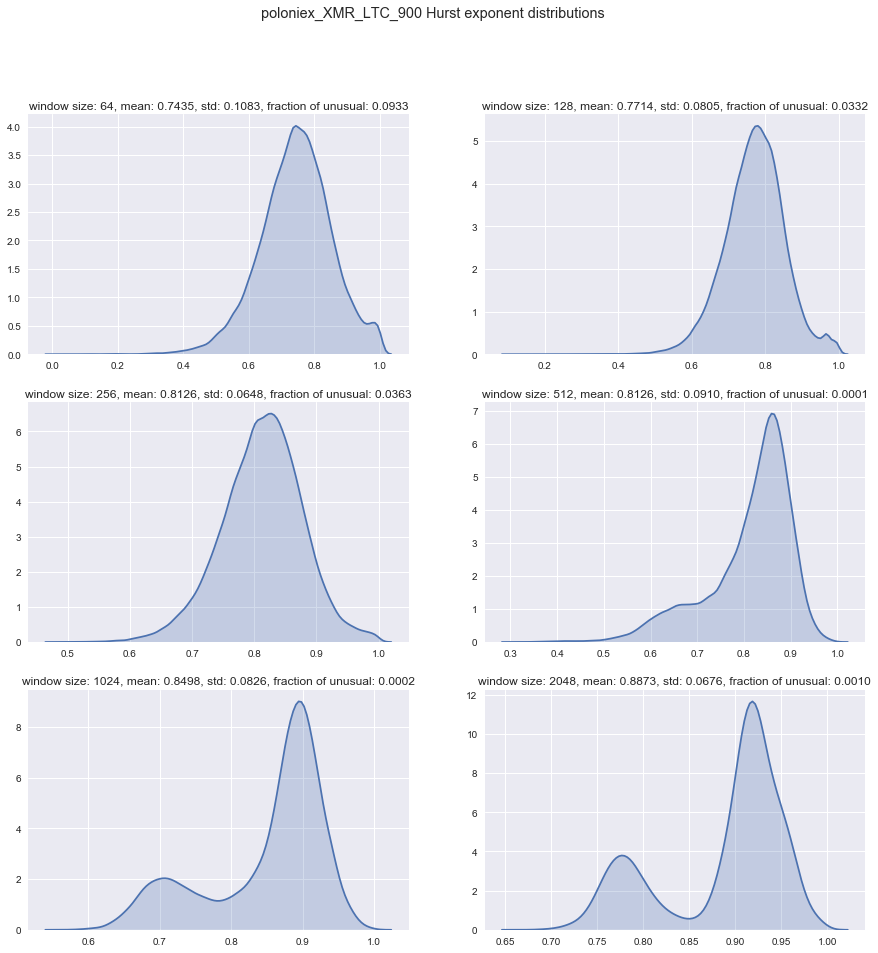

In [14]:
plot_hurst_exp_distribution(poloniex_xmr_ltc_900_hurst_exps_clean, window_sizes, fracs_unusual, data_name='poloniex_XMR_LTC_900')

Now, repeat the same actions for a different pair (USDT/ETH) and different candlestick period (300 seconds).

In [15]:
# USDT/ETH pair close prices with candlestick period of 300 seconds
poloniex_usdt_eth_300_df = pd.read_csv(os.path.join(data_dir, 'poloniex_USDT_ETH_300.csv'), index_col=0)

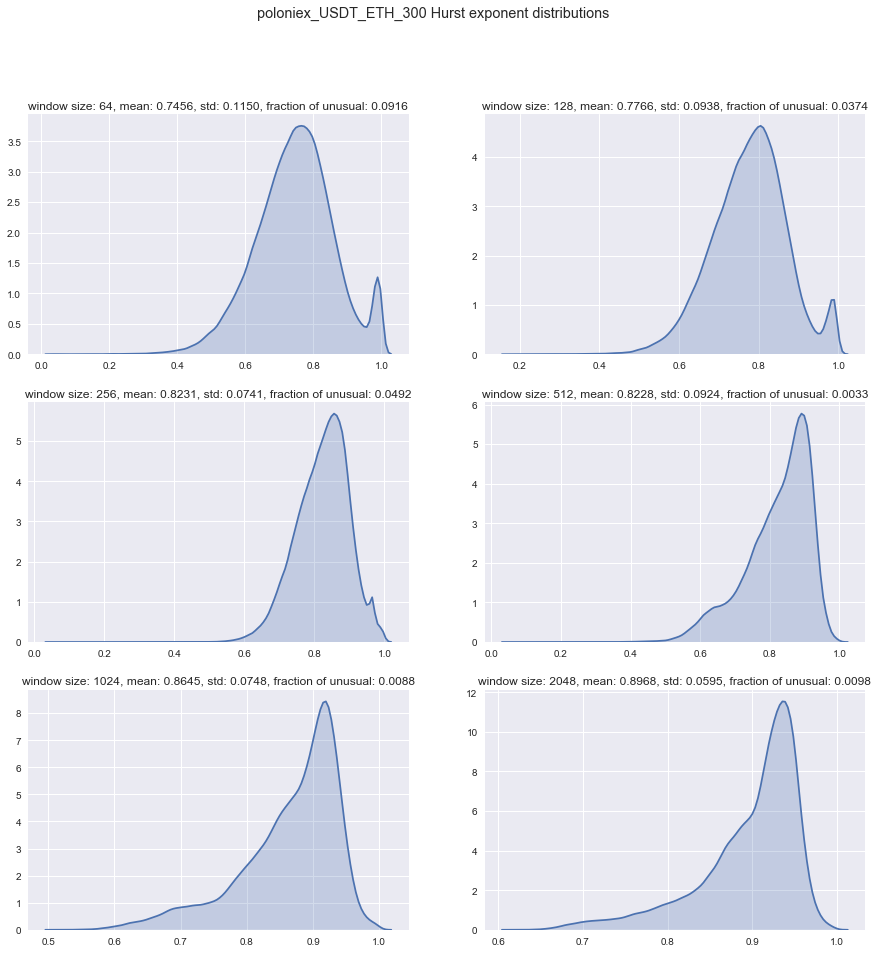

In [16]:
poloniex_usdt_eth_300_hurst_exps = calc_samples_hurst_exp(df_ohlc=poloniex_usdt_eth_300_df, window_sizes=window_sizes)
poloniex_usdt_eth_300_hurst_exps_clean, fracs_unusual = remove_unusual(remove_nans(poloniex_usdt_eth_300_hurst_exps))
plot_hurst_exp_distribution(poloniex_usdt_eth_300_hurst_exps_clean, window_sizes, fracs_unusual, data_name='poloniex_USDT_ETH_300')

And another pair (BTC/ETH) with the same candlestick period of 300.

In [17]:
# BTC/ETH pair close prices with candlestick period of 300 seconds
poloniex_btc_eth_300_df = pd.read_csv(os.path.join(data_dir, 'poloniex_BTC_ETH_300.csv'), index_col=0)

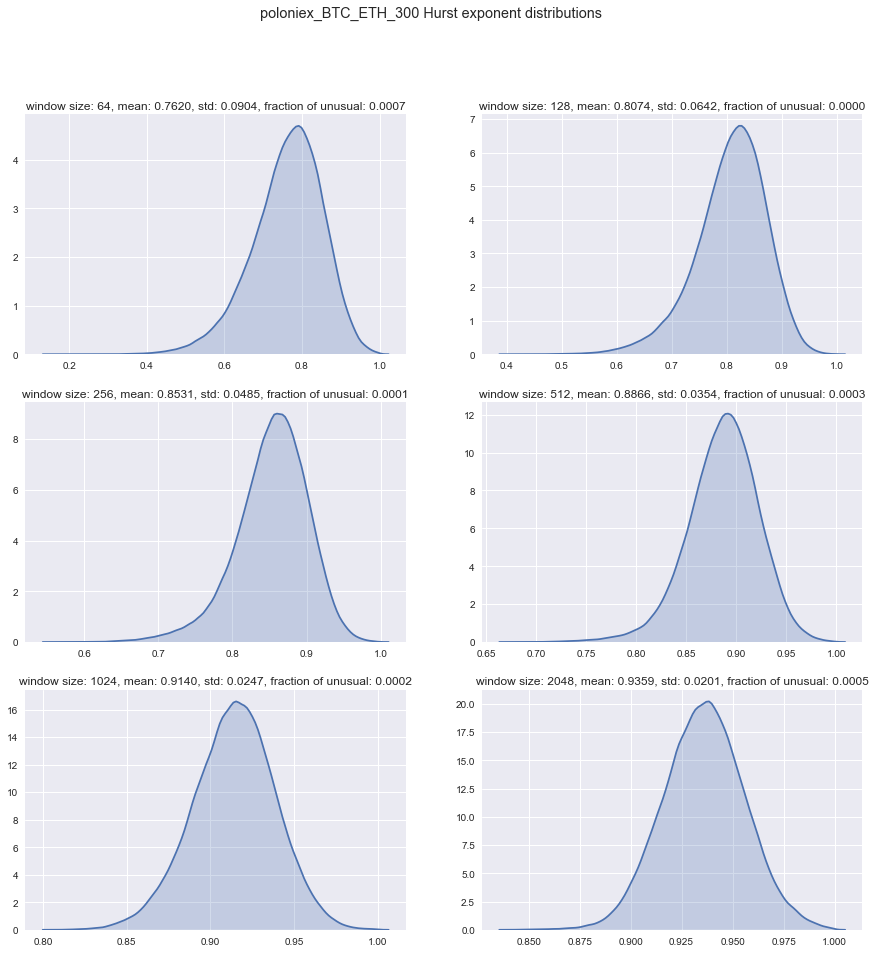

In [18]:
poloniex_btc_eth_300_hurst_exps = calc_samples_hurst_exp(df_ohlc=poloniex_btc_eth_300_df, window_sizes=window_sizes)
poloniex_btc_eth_300_hurst_exps_clean, fracs_unusual = remove_unusual(remove_nans(poloniex_btc_eth_300_hurst_exps))
plot_hurst_exp_distribution(poloniex_btc_eth_300_hurst_exps_clean, window_sizes, fracs_unusual, data_name='poloniex_BTC_ETH_300')

Lastly, try BTC/USD pair with the lowest candlestick period that is available to me at the moment (60 seconds).

In [19]:
# try BTC/USD pair close prices with candlestick period of 60 seconds
bitstamp_usd_60_df = pd.read_csv(os.path.join(data_dir, 'bitstamp_usd_jan-jun-2016.csv'), index_col=0)
bitstamp_usd_60_df.rename(columns = {'Close':'close'}, inplace = True) # 'C' is uppercase in bitstamp chart data

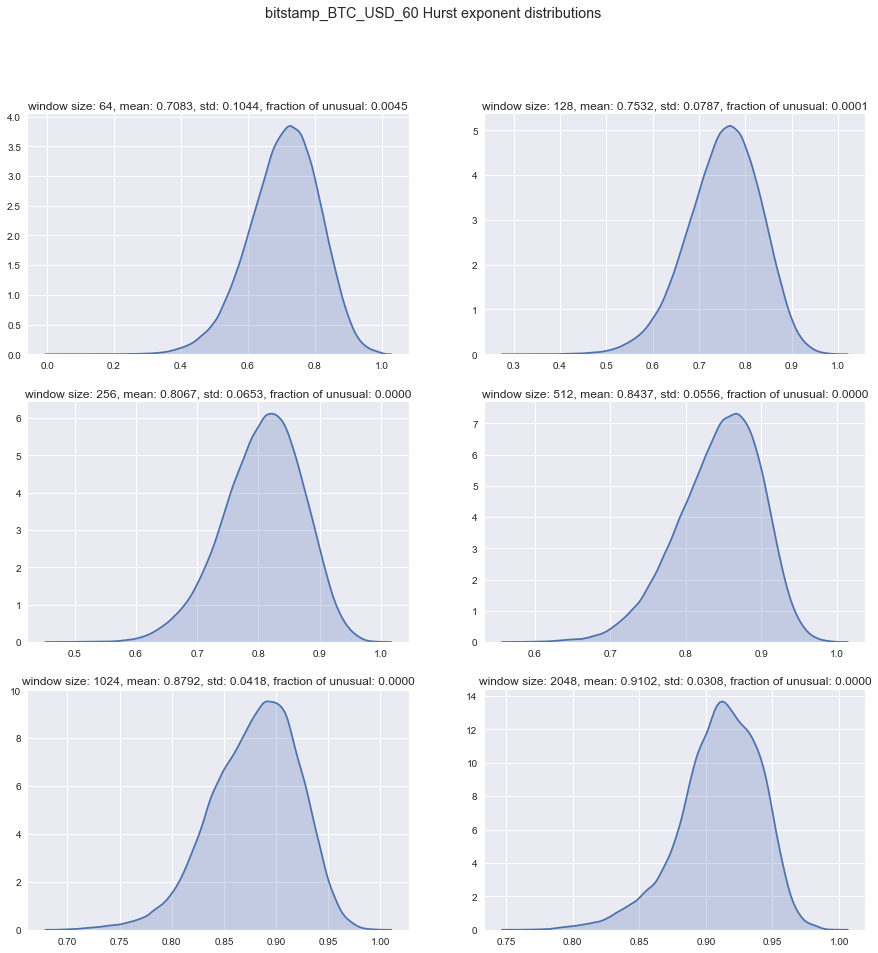

In [20]:
bitstamp_usd_60_hurst_exps = calc_samples_hurst_exp(df_ohlc=bitstamp_usd_60_df, window_sizes=window_sizes)
bitstamp_usd_60_hurst_exps_clean, fracs_unusual = remove_unusual(remove_nans(bitstamp_usd_60_hurst_exps))
plot_hurst_exp_distribution(bitstamp_usd_60_hurst_exps_clean, window_sizes, fracs_unusual, 'bitstamp_BTC_USD_60')

## Hurst exponent meaning

What all these distributions mean anyway? Let's look at some time vs price plots with different Hurst exponent values. Data from the last analyzed pair (BTC/USD) with window size 64 is used; this window size contains the most variability (***SD = 0.1044***) when compared to others, thus it's easier to find very different Hurst exponent values.

Need to get time windows corresponding to calculated Hurst exponent values first.

In [21]:
windows_64 = sample_time_windows(bitstamp_usd_60_df, window_size=64)

First, let's look at a time window where the close price exhibits strong mean-reverting behaviour (***H << 0.5***).

H = 0.0234


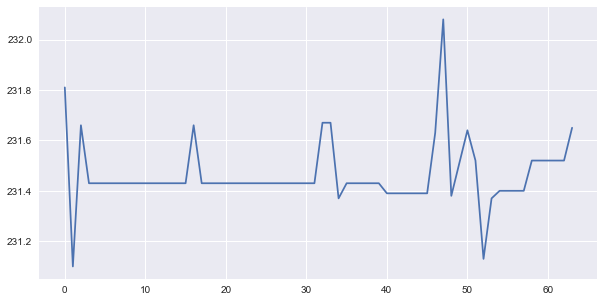

In [22]:
mpl.rcParams['figure.figsize'] = (10,5)
window_idx = np.argmax(bitstamp_usd_60_hurst_exps[0] < 0.03)
plt.plot(np.linspace(0, 63, 64), windows_64[window_idx])
print("H = {:0.4f}".format(bitstamp_usd_60_hurst_exps[0][window_idx]))

Now, on to a time window where the close price follows geometric random walk model (***H ≈ 0.5***).

H = 0.5041


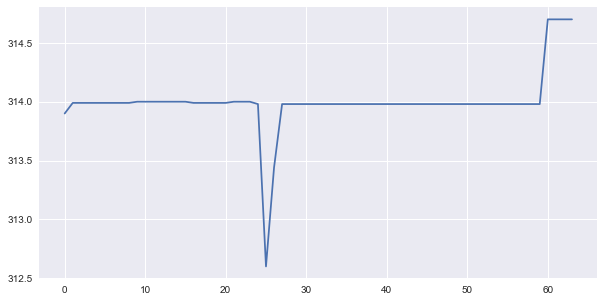

In [23]:
window_idx = np.argmax(np.logical_and(bitstamp_usd_60_hurst_exps[0] < 0.51, 
                                      bitstamp_usd_60_hurst_exps[0] > 0.49))
plt.plot(np.linspace(0, 63, 64), windows_64[window_idx])
print("H = {:0.4f}".format(bitstamp_usd_60_hurst_exps[0][window_idx]))

Maybe time window size of 64 is too small for chart data with candlestick period of 60 seconds after all. If the 0.5% dip wasn't there around timestep 25, the ***H*** value for this time series would be very close to 1. Better to check how ***H ≈ 0.5*** for a time series with larger window size.

Loading windows of size 256...

In [24]:
windows_256 = sample_time_windows(bitstamp_usd_60_df, window_size=256)

H = 0.5090


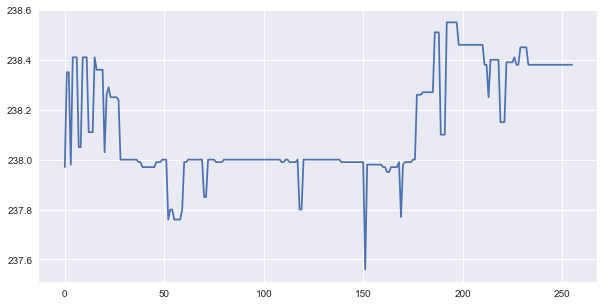

In [25]:
window_idx = np.argmax(np.logical_and(bitstamp_usd_60_hurst_exps[2] < 0.51, 
                                      bitstamp_usd_60_hurst_exps[2] > 0.49))
plt.plot(np.linspace(0, 255, 256), windows_256[window_idx])
print("H = {:0.4f}".format(bitstamp_usd_60_hurst_exps[2][window_idx]))

This looks like a random walk a lot more.

Now, it would be interesting to look at a time series exhibiting strong positive autocorrelation (***H >> 0.5***).

H = 0.9934


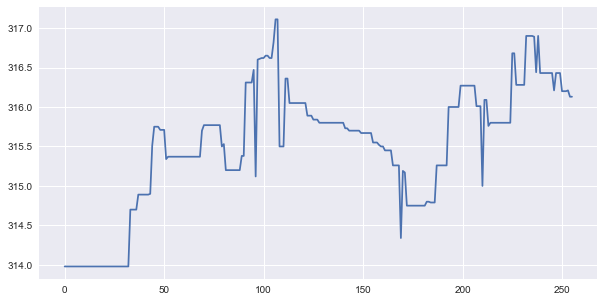

In [26]:
window_idx = np.argmax(bitstamp_usd_60_hurst_exps[2] > 0.99)
plt.plot(np.linspace(0, 255, 256), windows_256[window_idx])
print("H = {:0.4f}".format(bitstamp_usd_60_hurst_exps[2][window_idx]))

## Answering initial question
So, back to the initial question: we are looking for window size ***W***, such that ***H > 0.5 + ε*** for ***n*** time series of length ***W*** in a sample of size ***N*** such that ***n/N > ω***, where ***ε*** and ***ω*** are some threshold values and ***n < N***.

Of course the answer depends on the candlestick period and on selected threshold values ***ε*** and ***ω***. 

**ε** determines how conservative we want to be when saying that some H value corresponds positive autocorrelation. 

***ω*** determines the fraction of ***n*** in ***N*** that we deem indicates that positive autocorrelation is consistent among all ***N*** sampled time windows.

There's no straightforward way to pick these values, so let's just pick ***ε = 0.25*** and ***ω = 0.75***, and see if results make sense. This means that we want the smallest window size ***W***, such that more than 75% of sampled time series with length ***W*** have ***H > 0.75***.

In [42]:
def smallest_W_with_constraints(hurst_exps, window_sizes, epsilon, omega):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")   # suppress warnings about doing comparisons with NaNs
        W_map = dict(zip([x for x in range(len(window_sizes))], window_sizes))
        for i, same_W_hurst_exps in enumerate(hurst_exps):
            if (np.sum(same_W_hurst_exps > (0.5 + epsilon)) / same_W_hurst_exps.shape[0]) > 0.75:
                print("Optimal W = {}".format(W_map[i]))
                return W_map[i]
        return None

In [43]:
W = smallest_W_with_constraints(poloniex_xmr_ltc_900_hurst_exps, window_sizes=window_sizes, epsilon=0.25, omega=0.75)

Optimal W = 256


For the examined XMR/LTC trading pair's close prices with candlestick period of 900 seconds minimum window size of 256 fits our constraints. We can plot some random time series windows of that pair with the optimal window size.

In [44]:
mpl.rcParams['figure.figsize'] = (15,15)
def plot_random_windows(df, hurst_exps, W, numplots):
    assert len(numplots) is 2
    n_row, n_col = numplots
    inv_W_map = dict(zip(window_sizes, [x for x in range(len(window_sizes))]))
    windows = sample_time_windows(df_ohlc=df, window_size=W)
    f, axarr = plt.subplots(n_row, n_col)
    for r in range(n_row):
        for c in range(n_col):           
            t = randint(0, windows.shape[0])
            axarr[r, c].plot(np.linspace(0, W-1, W), windows[t]) # plot random time window t
            axarr[r, c].set_title('H={}'.format(hurst_exps[inv_W_map[W]][t]))

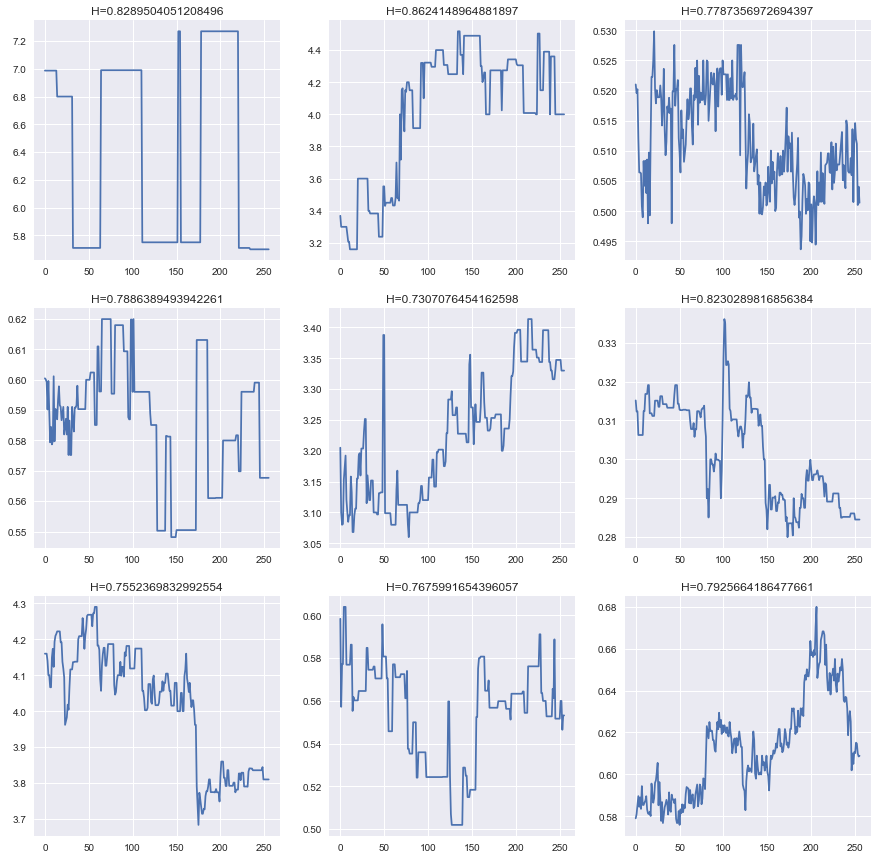

In [45]:
plot_random_windows(df=poloniex_xmr_ltc_900_df, hurst_exps=poloniex_xmr_ltc_900_hurst_exps, W=W, numplots=[3,3])

Repeat the same for other examined trading pairs.

Optimal W = 256


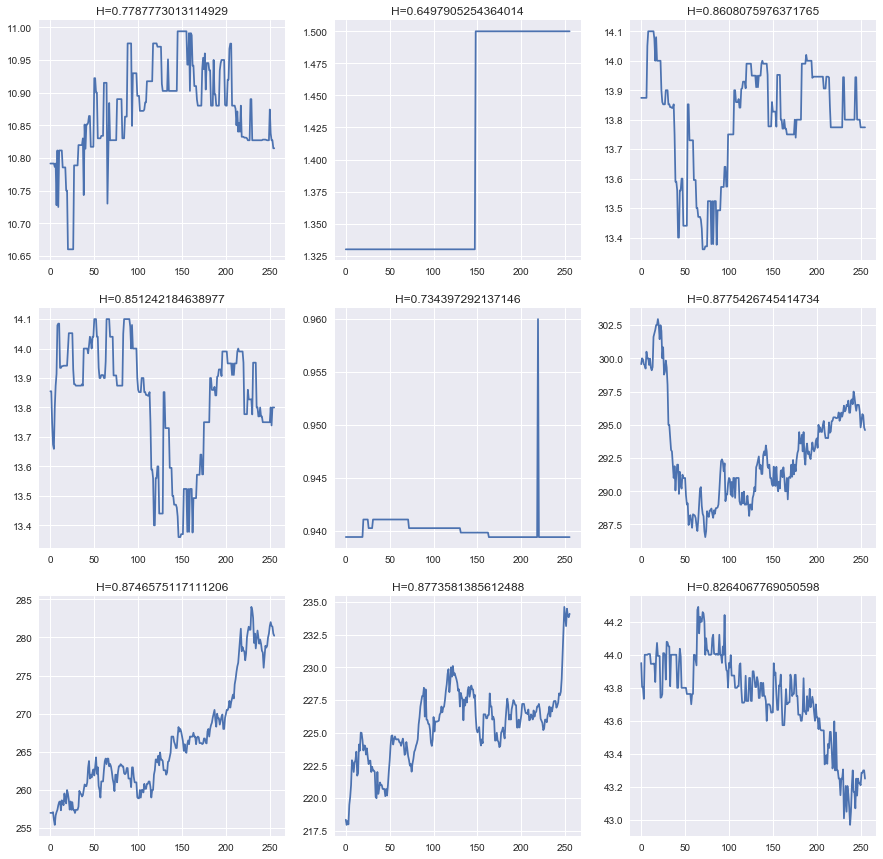

In [46]:
W = smallest_W_with_constraints(poloniex_usdt_eth_300_hurst_exps, window_sizes=window_sizes, epsilon=0.25, omega=0.75)
plot_random_windows(df=poloniex_usdt_eth_300_df, hurst_exps=poloniex_usdt_eth_300_hurst_exps, W=W, numplots=[3,3])

Optimal W = 128


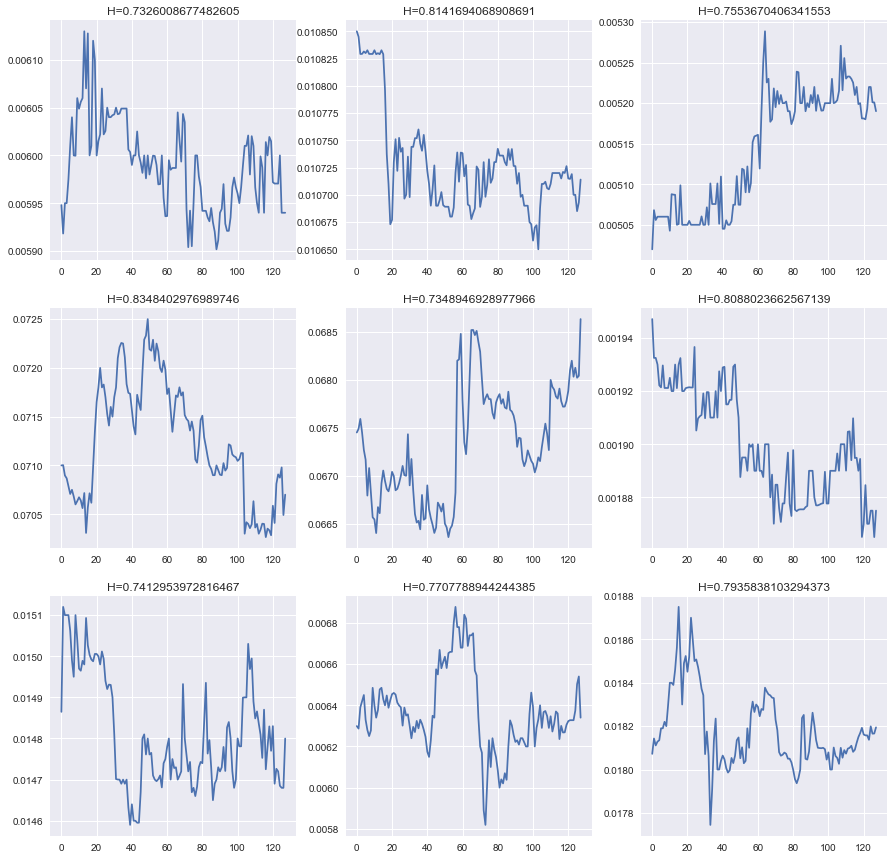

In [47]:
W = smallest_W_with_constraints(poloniex_btc_eth_300_hurst_exps, window_sizes=window_sizes, epsilon=0.25, omega=0.75)
plot_random_windows(df=poloniex_btc_eth_300_df, hurst_exps=poloniex_btc_eth_300_hurst_exps, W=W, numplots=[3,3])

Optimal W = 256


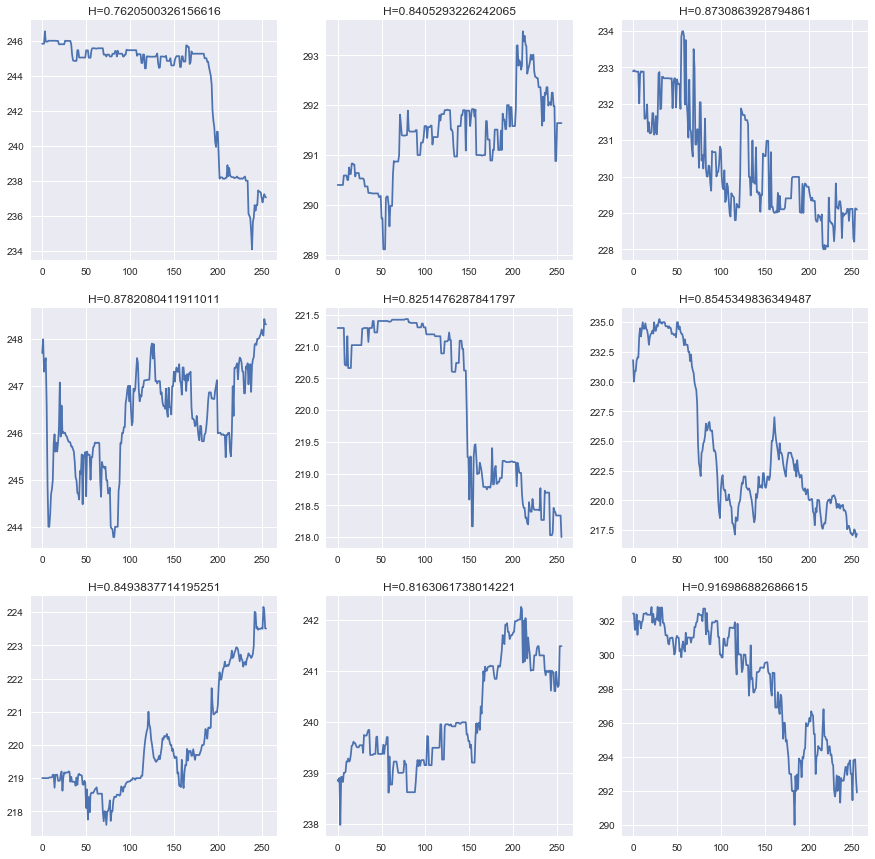

In [48]:
W = smallest_W_with_constraints(bitstamp_usd_60_hurst_exps, window_sizes=window_sizes, epsilon=0.25, omega=0.75)
plot_random_windows(df=bitstamp_usd_60_df, hurst_exps=bitstamp_usd_60_hurst_exps, W=W, numplots=[3,3])

## Conclusion

It looks like the time series window size of 256 is optimal for the examined market chart data, if the goal is to have more than 75% of sampled windows to exhibit somewhat average positive autocorrelation (H > 0.75).

Hurst exponent estimation has a few notable limitations that are important to keep in mind while using it: 

1) R/S estimation results can be greatly affected by outliers.

2) R/S estimation is not accurate for small window sizes (W < 50 in a referenced paper).

How the results of this writing can be applied to data preprocessing and dataset labeling of a fixed-input size ML models is outside of the scope of this writing.